In [1]:
! pip install geopandas networkx shapely

In [8]:
!pip install fiona

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 50.7 MB/s eta 0:00:00


In [9]:
import os
import fiona
import geopandas as gpd

from shapely.geometry import shape, mapping

# Path to your original GeoJSON
in_geojson = "/content/filtered_output_2_small.geojson"
out_fixed = "/content/filtered_output_2_small_fixed.geojson"
min_points = 2  # Minimum number of points required for a valid LineString

# Step 1: Read using Fiona and fix geometries
with fiona.open(in_geojson, 'r') as src:
    meta = src.meta
    valid_features = []

    for feat in src:
        geom = feat['geometry']
        if geom is None:
            continue

        if geom['type'] == 'LineString':
            if len(geom['coordinates']) >= min_points:
                valid_features.append(feat)

        elif geom['type'] == 'MultiLineString':
            valid_coords = [line for line in geom['coordinates'] if len(line) >= min_points]
            if len(valid_coords) > 0:
                feat['geometry'] = {
                    'type': 'MultiLineString',
                    'coordinates': valid_coords
                }
                valid_features.append(feat)

# Step 2: Write fixed features to a new GeoJSON file
with fiona.open(out_fixed, 'w', driver='GeoJSON', schema=meta['schema'], crs=meta['crs']) as dst:
    for feat in valid_features:
        dst.write(feat)

# Step 3: Read the cleaned GeoJSON with GeoPandas
gdf_fixed = gpd.read_file(out_fixed)

# Done! Preview the cleaned GeoDataFrame
print(gdf_fixed.head())


   name name:en      highway surface smoothness width lanes oneway bridge  \
0  None    None  residential    None       None  None  None   None   None   
1  None    None  residential    None       None  None  None   None   None   
2  None    None  residential    None       None  None  None   None   None   
3  None    None  residential    None       None  None  None   None   None   
4  None    None  residential    None       None  None  None   None   None   

  layer source name:hi name:ta      osm_id   osm_type  \
0  None  maxar    None    None  1078189875  ways_line   
1  None  maxar    None    None  1078986677  ways_line   
2  None  maxar    None    None  1078986679  ways_line   
3  None   None    None    None  1081671565  ways_line   
4  None  maxar    None    None  1081667569  ways_line   

                                            geometry  
0  LINESTRING (76.85029 28.25832, 76.84956 28.258...  
1  LINESTRING (76.84747 28.2639, 76.8473 28.2639,...  
2  LINESTRING (76.84984 28.26

In [11]:
import geopandas as gpd
import networkx as nx
from shapely.geometry import LineString, Point
from shapely.strtree import STRtree

# Load the GeoJSON
gdf = gpd.read_file("/content/filtered_output_2_small_fixed.geojson")

# Keep only valid LineStrings
gdf = gdf[gdf.geometry.type == 'LineString']
gdf = gdf[gdf.geometry.is_valid]

# Extract lines
lines = list(gdf.geometry)

# Step 1: Build spatial index
tree = STRtree(lines)

# Step 2: Initialize graph
G = nx.Graph()

# Step 3: Detect intersections
for i, line in enumerate(lines):
    # Find potentially intersecting lines (excluding self)
    candidates = [l for l in tree.query(line) if l != line and isinstance(l, LineString)]

    for other in candidates:
        inter = line.intersection(other)

        # Only add real point intersections
        if isinstance(inter, Point):
            G.add_node((inter.x, inter.y))

# Step 4: Add endpoints of all lines as graph nodes and edges
for line in lines:
    coords = list(line.coords)
    pt1 = coords[0]
    pt2 = coords[-1]

    G.add_node(pt1)
    G.add_node(pt2)
    G.add_edge(pt1, pt2, geometry=line)

# Final graph summary
print(f"✅ Total nodes: {G.number_of_nodes()}")
print(f"✅ Total edges: {G.number_of_edges()}")

✅ Total nodes: 4020
✅ Total edges: 2218


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128506 (\N{WORLD MAP}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


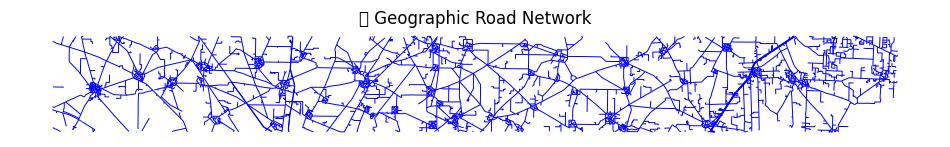

In [13]:
import geopandas as gpd
from shapely.geometry import LineString

# Extract edges and their geometries
edge_lines = []
for u, v, data in G.edges(data=True):
    if 'geometry' in data:
        edge_lines.append(data['geometry'])
    else:
        edge_lines.append(LineString([u, v]))  # fallback

# Create GeoDataFrame
gdf_edges = gpd.GeoDataFrame(geometry=edge_lines, crs="EPSG:4326")

# Plot
gdf_edges.plot(figsize=(12, 12), linewidth=0.7, color='blue')
plt.title("🗺️ Geographic Road Network")
plt.axis('off')
plt.show()

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


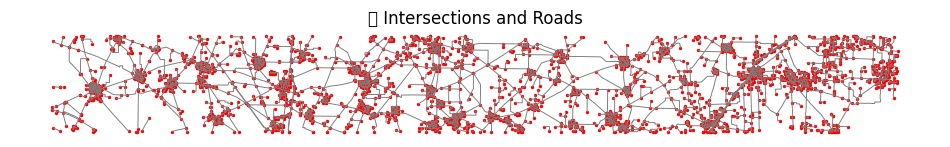

In [14]:
from shapely.geometry import Point

# Convert nodes to Points
node_points = [Point(xy) for xy in G.nodes()]
gdf_nodes = gpd.GeoDataFrame(geometry=node_points, crs="EPSG:4326")

# Plot edges and nodes
base = gdf_edges.plot(figsize=(12, 12), linewidth=0.7, color='gray')
gdf_nodes.plot(ax=base, color='red', markersize=2)
plt.title("📍 Intersections and Roads")
plt.axis('off')
plt.show()


In [15]:
!pip install contextily

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 44.8 MB/s eta 0:00:00


<ipython-input-16-001638fe31e7>:21: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


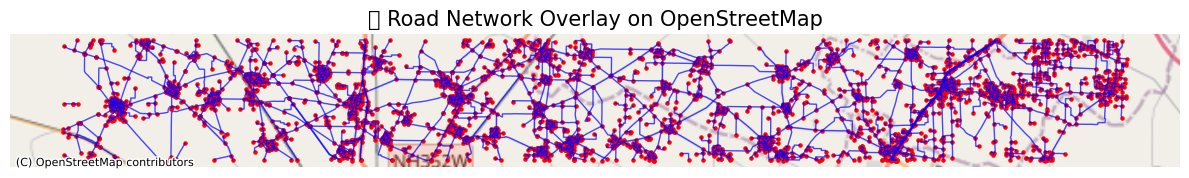

In [16]:
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt

# Reproject to Web Mercator (EPSG:3857) for compatibility with OSM tiles
gdf_edges_web = gdf_edges.to_crs(epsg=3857)
gdf_nodes_web = gdf_nodes.to_crs(epsg=3857)

# Plot edges with OSM basemap
fig, ax = plt.subplots(figsize=(12, 12))

gdf_edges_web.plot(ax=ax, linewidth=1, edgecolor='blue', alpha=0.7)
gdf_nodes_web.plot(ax=ax, color='red', markersize=5)

# Add OpenStreetMap basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Clean plot
ax.set_axis_off()
plt.title("📍 Road Network Overlay on OpenStreetMap", fontsize=15)
plt.tight_layout()
plt.show()


In [17]:
!pip install python-louvain

In [19]:
!pip install community

In [22]:
import community.community_louvain as community_louvain
import networkx as nx
import matplotlib.pyplot as plt

# Run Louvain community detection
partition = community_louvain.best_partition(G)

# Add community info to each node
nx.set_node_attributes(G, partition, 'community')

In [24]:
!pip install osmnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.9/99.9 kB 8.6 MB/s eta 0:00:00


<ipython-input-27-43754754e81b>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20', len(communities))


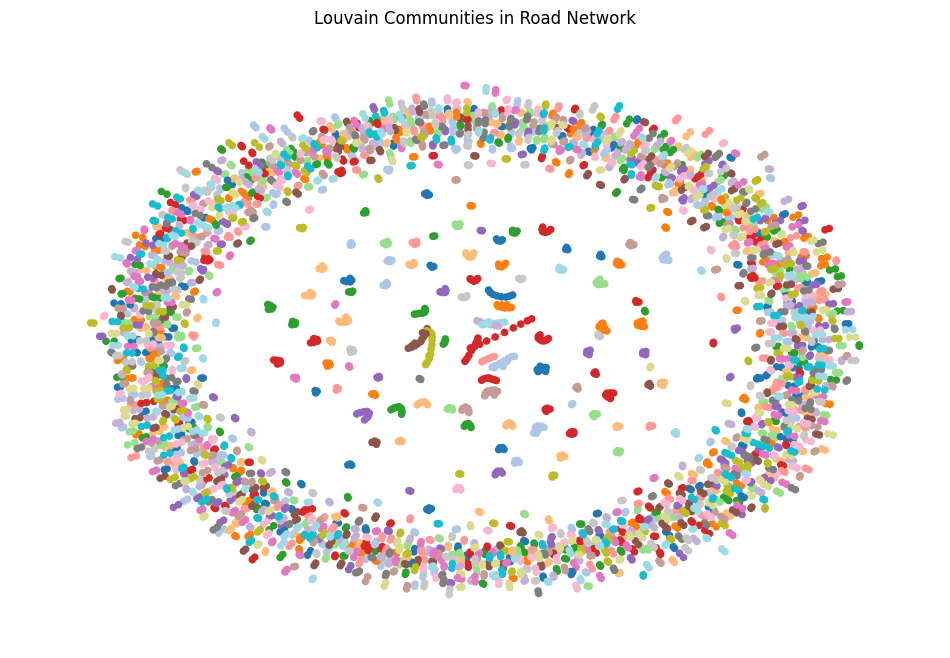

In [27]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Generate layout
pos = nx.spring_layout(G, seed=42)

# Create color map
communities = set(partition.values())
colors = cm.get_cmap('tab20', len(communities))

# Draw graph
plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(G, pos, node_size=20,
                       node_color=[partition[node] for node in G.nodes()],
                       cmap=colors)
nx.draw_networkx_edges(G, pos, alpha=0.3)
plt.axis('off')
plt.title("Louvain Communities in Road Network")
plt.show()

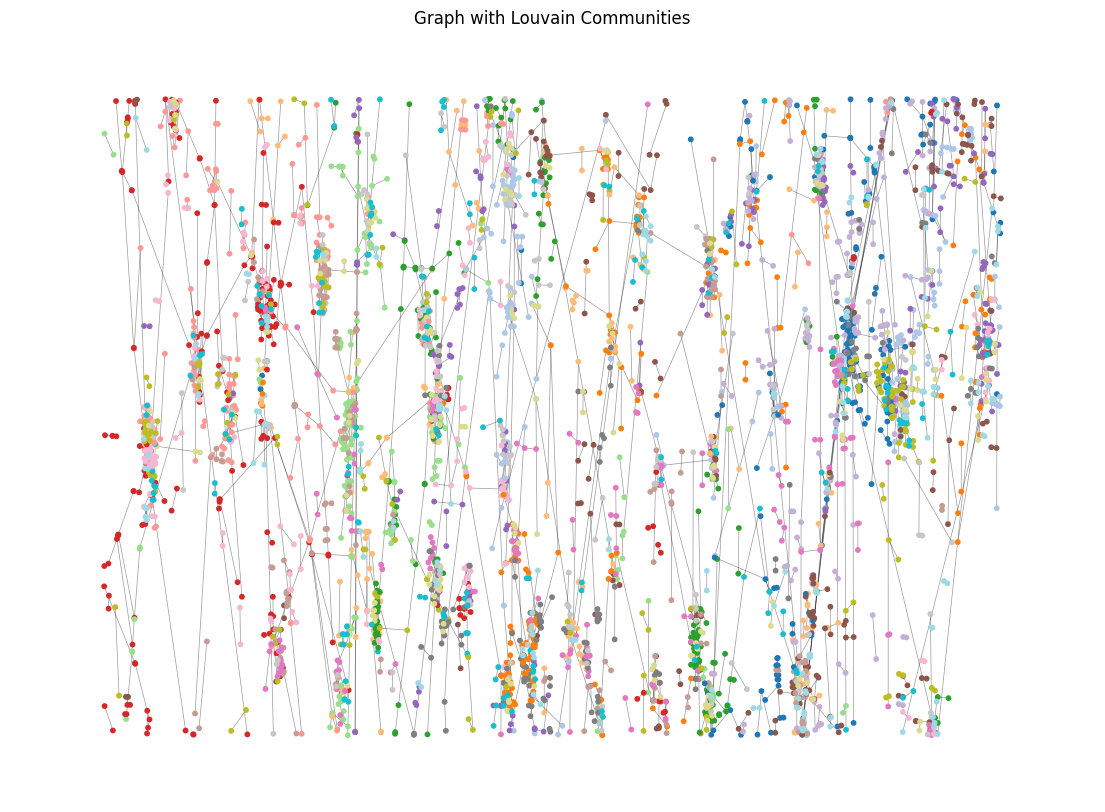

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

# Prepare colormap
num_communities = len(set(partition.values()))
cmap = plt.colormaps.get_cmap('tab20')
colors = [cmap(i) for i in np.linspace(0, 1, num_communities)]

# Assign color to each node based on community
node_colors = [colors[partition[node]] for node in G.nodes()]

# Since nodes are coordinate tuples, just map them to themselves
pos = {node: node for node in G.nodes()}

# Plot
plt.figure(figsize=(14, 10))
nx.draw_networkx_nodes(G, pos, node_size=10, node_color=node_colors)
nx.draw_networkx_edges(G, pos, alpha=0.4, width=0.5)
plt.title("Graph with Louvain Communities")
plt.axis('off')
plt.show()


In [32]:
import folium
from folium import Map, PolyLine
import random
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Center of map (mean location of all nodes)
lats = [coord[1] for coord in G.nodes()]
lons = [coord[0] for coord in G.nodes()]
center = [sum(lats) / len(lats), sum(lons) / len(lons)]

# Create folium map
m = folium.Map(location=center, zoom_start=15, tiles='OpenStreetMap')

# Generate colors for communities
num_comms = len(set(partition.values()))
colors = cm.get_cmap('tab20', num_comms)
community_colors = {
    comm: mcolors.to_hex(colors(comm)) for comm in range(num_comms)
}

# Add edges colored by community
for u, v in G.edges():
    # Use community of the starting node
    comm = partition.get(u, 0)
    color = community_colors.get(comm, "#000000")

    # u and v are (lon, lat)
    folium.PolyLine(
        locations=[(u[1], u[0]), (v[1], v[0])],  # Convert to (lat, lon)
        color=color,
        weight=3,
        opacity=0.8
    ).add_to(m)

# Show the map
m

<ipython-input-32-d9ac1bac84be>:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20', num_comms)
